In [70]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt, yaml
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import albumentations as A # Library for augmentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
from PIL import Image
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn as nn
# from torchvision.transforms.functional import Interpolate
import torch.nn.functional as Func
from datetime import datetime


In [101]:
class_config_path = '../config/onehot_class_sample.yaml'
with open(class_config_path, 'r') as file:
            classes = yaml.safe_load(file)
            
valid_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

def train_transform():
    return A.Compose([
        A.Sequential([
            # A.RandomCrop(width=640, height=480),
            A.Resize(width=84, height=84),
            A.RandomRotate90(p=1),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1),
    ],
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'])
    # bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def normalize_bboxes(bboxes, width, height):
    normalized_bboxes = []
    normalized_bboxes.append([x_min/width, y_min/height, x_max/width, y_max/height] for x_min, y_min, x_max, y_max in bboxes)
    print('normalized = ', list(normalized_bboxes))   
    return normalized_bboxes

def label_transform(labels): #One-hot encoding
    target = np.zeros(len(classes), dtype=int)
    for label in labels:
        if label in classes:
            index = classes[label]
            target[index] = 1
    return target

def normalize_keypoints(keypoints, width, height):
    normalized_keypoints = []
    for x, y in keypoints:
        normalized_keypoints.append([x/width, y/height])
    return normalized_keypoints

def denormalize_keypoints(keypoints, width, height):
    denormalized_keypoints = []
    for x, y in keypoints:
        denormalized_keypoints.append([x*width, y*height])
    return denormalized_keypoints

def dk(keypoints, width, height):
    denormalized_keypoints = []
    # for x, y in keypoints:
    denormalized_keypoints.append([keypoints[0]*width, keypoints[1]*height])
    return denormalized_keypoints

In [78]:
class DownsampleCNN(nn.Module):
    def __init__(self):
        super(DownsampleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_final = nn.Conv2d(64, 3, kernel_size=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((84, 84))

    def forward(self, x):
        x = Func.relu(self.conv1(x))
        x = self.pool(Func.relu(self.conv2(x)))
        x = self.pool(Func.relu(self.conv3(x)))
        x = self.conv_final(x)
        x = self.adaptive_pool(x)
        return x
    
class ResNet50Modified(nn.Module):
    def __init__(self):
        super(ResNet50Modified, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet50.children())[:-2])
        self.conv_final = nn.Conv2d(2048, 3, kernel_size=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((84, 84))

    def forward(self, x):
        x = self.features(x)
        x = self.conv_final(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(0)
        return x

In [79]:
class ClassDataset(Dataset):
    def __init__(self, dataset_folder, transform=None, label_transform=None, normalize_keypoints=None, demo=False):
        self.dataset_folder = dataset_folder
        self.transform = transform
        self.label_transform = label_transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = self.load_data(dataset_folder)
        self.downsample_cnn = ResNet50Modified()
        self.normalize_keypoints = normalize_keypoints
        # self.denormalize_keypoints = denormalize_keypoints
        #print (self.imgs_files)

    def load_data(self, dataset_folder):
        images_path = os.path.join(self.dataset_folder,"images/") #self.dataset_folder
        annotations_path = os.path.join(self.dataset_folder,"annotations/")
        # j_files = []
        j_data = []
        for file in os.listdir(images_path):
            if file.endswith(".jpg"):
                json_path = os.path.join(annotations_path, file.split('.')[0] + '.json')
                with open(json_path) as f:
                    json_load = json.load(f)
                    # j_files.append({'json_path':json_path, 'image_path':file})
                    ## Implemented Pandas here instead of json load ##
                    for item in json_load['shapes']:
                        points = [value for row in item['points'] for value in row]
                        j_data.append({'image':  os.path.join(images_path,file),
                                     'label': item['label'],
                                     'points':points })
        json_data = pd.DataFrame(j_data)
        # json_files = pd.DataFrame(j_files)
        return json_data

    def get_keypoint(self, bboxes):
        centers = []
        for bbox in bboxes:
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            centers.append((center_x, center_y))
        return centers
    
    def __len__(self):
        return len(self.imgs_files)

    def __getitem__(self, idx):
        img_path, label, bboxes_original = self.imgs_files.iloc[idx]
        label = [label]
        bboxes_original = [bboxes_original]
        keypoint_original = self.get_keypoint(bboxes_original)
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        if self.transform:
            # transformed = self.transform(image=img_original, bboxes=bboxes_original, class_labels=label)
            transformed = self.transform(image=img_original, keypoints=keypoint_original, class_labels=label)
            img = transformed['image']
            # bboxes = transformed['bboxes']
            keypoints = transformed['keypoints']
            label = self.label_transform(label)
            # bboxes = normalize_bboxes(bboxes, img.shape[0], img.shape[1])

        else:
            # img, bboxes = img_original, bboxes_original
            img, keypoints = img_original, keypoint_original

        target = {}
        # print('keypoints = ', keypoints)
        norm_keys = self.normalize_keypoints(keypoints, img.shape[0], img.shape[1])
        target["keypoints"] = torch.as_tensor(norm_keys, dtype=torch.float32)
        
        # target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        keyp = torch.as_tensor(keypoints, dtype=torch.float32)
        target["labels"] = torch.as_tensor(label, dtype=torch.int64)
        encoded_label = torch.as_tensor(target["labels"], dtype=torch.int64)
        
        # print('encoded_label = ', encoded_label)
        
        labels = torch.as_tensor(label, dtype=torch.int64)

        img = F.to_tensor(img)
        # resized_img = self.downsample_cnn(img.unsqueeze(0))

        label_reshaped = encoded_label.view(1, 1, 4).repeat(1, 84, 21) 
        label_reshaped = label_reshaped[:, :, :84]

        concatenated_tensor = torch.cat((img, label_reshaped), dim=0)

        return img, target, concatenated_tensor, labels
    

In [80]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [81]:
KEYPOINTS_FOLDER_TRAIN = '../dataset/robocup_test_dataset/'
train_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"train/") #self.dataset_folder
val_path = os.path.join(KEYPOINTS_FOLDER_TRAIN,"val/")

train_dataset = ClassDataset(train_path, transform=train_transform(),label_transform=label_transform, normalize_keypoints=normalize_keypoints, demo=True)
valid_dataset = ClassDataset(val_path, transform=train_transform(),label_transform=label_transform,normalize_keypoints=normalize_keypoints, demo=True)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

# dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(),label_transform=label_transform, demo=True)
# data_loader = DataLoader(dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

In [112]:
# encoded label is an array of [0 1 0 0] and image shape is torch.Size([3, 224, 224])
# so reshape the encoded label to torch.Size([1, 224, 224])

# have a method to fuse the encoded label and the image into a single tensor
# so the output of the method should be torch.Size([4, 224, 224])

iterator = iter(valid_loader)
images, targets, concat_vec, labels  = next(iterator)
image_number = 0

print(concat_vec[image_number].shape)
print(targets[image_number]['keypoints'], targets[image_number]['labels'])
keypoints = denormalize_keypoints(targets[image_number]['keypoints'], concat_vec[image_number].shape[1], concat_vec[image_number].shape[2])
print ('denormalized',[[int(t.item()) for t in sublist] for sublist in keypoints])


# img[image_number].shape

torch.Size([4, 84, 84])
tensor([[0.6256, 0.4798]]) tensor([0, 0, 0, 1])
denormalized [[52, 40]]


In [83]:
class RnDLossFunction(nn.Module):
    def __init__(self):
        super(RnDLossFunction, self).__init__()
        self.classification_loss = nn.CrossEntropyLoss()
        self.localization_loss = nn.SmoothL1Loss()

    def forward(self, preds, class_targets, bbox_targets):
        class_preds, bbox_preds = preds
        class_loss = self.classification_loss(class_preds, class_targets)
        bbox_loss = self.localization_loss(bbox_preds, bbox_targets)
        return class_loss + bbox_loss

In [84]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=20, num_keypoints=1): 
        super(CustomResNet50, self).__init__()
        
        self.num_keypoints = num_keypoints
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc_cls = nn.Linear(self.resnet50.fc.in_features, num_classes)
        self.fc_kpts = nn.Linear(self.resnet50.fc.in_features, self.num_keypoints * 2)
        self.resnet50.fc = nn.Identity()
        
    def forward(self, x):
        features = self.resnet50(x)
        class_outputs = self.fc_cls(features)
        keypoint_outputs = self.fc_kpts(features)
        return class_outputs, keypoint_outputs.reshape(-1, self.num_keypoints, 2)

In [85]:
num_classes = 4 
model = CustomResNet50(num_classes=num_classes, num_keypoints=1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device = ', device)
model.to(device)

# criterion = RnDLossFunction() 
criterion = nn.CrossEntropyLoss()
criterion_kpt = torch.nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
temp = None


device =  cpu


In [87]:
def train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=25):
    train_losses = []
    valid_losses = []
    

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_kpt_loss = 0.0

        for images, targets, concat_vecs, labels in train_loader:
            
            labels = [label.to(device) for label in labels]
            # labels = torch.stack([label.to(device) for label in labels])
            # concat_vecs = [concat_vec.to(device) for concat_vec in concat_vecs]
            concat_vecs = torch.stack(concat_vecs).to(device)
            # print('concat_vec = ', concat_vecs[4].shape)
            ground_truth_keypoints = torch.stack([target['keypoints'].to(device) for target in targets])
            optimizer.zero_grad()
            
            class_outputs, keypoint_outputs = model(concat_vecs)
            # outputs = model(concat_vecs)
            # print(outputs.shape, labels.shape)
            # print('labels = ', labels)
            labels_tensor = torch.stack(labels)
            class_indices = torch.argmax(labels_tensor, dim=1)
            loss = criterion(class_outputs, class_indices)
            loss_kpt = criterion_kpt(keypoint_outputs, ground_truth_keypoints)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * concat_vecs.size(0)
            total_kpt_loss += loss_kpt.item() * concat_vecs.size(0)
            # print(f'total_loss for {epoch}= ', total_loss)
        
        train_epoch_loss = total_train_loss / len(train_loader.dataset)
        train_kpt_loss = total_kpt_loss / len(valid_loader.dataset)

        train_losses.append(train_epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_epoch_loss}, Train Keypoint Loss: {train_kpt_loss}')
        

        model.eval()
        total_val_loss = 0.0
        total_kpt_loss_val = 0.0

        with torch.no_grad():
            for images, targets, concat_vecs, labels in valid_loader:
                concat_vecs = torch.stack(concat_vecs).to(device)
                labels = torch.stack([label.to(device) for label in labels])
                ground_truth_keypoints_val = torch.stack([target['keypoints'].to(device) for target in targets])

                class_outputs, keypoint_outputs = model(concat_vecs)
                labels_tuple = tuple(labels[i] for i in range(labels.size(0)))
                labels_tensor = torch.stack(labels_tuple)
                class_indices = torch.argmax(labels_tensor, dim=1)
                
                loss = criterion(class_outputs, class_indices)  
                loss_kpt_val = criterion_kpt(keypoint_outputs, ground_truth_keypoints_val)

                total_val_loss += loss.item() * concat_vecs.size(0)
                total_kpt_loss_val += loss_kpt.item() * concat_vecs.size(0)

        avg_valid_loss = total_val_loss / len(valid_loader.dataset)
        val_kpt_loss = total_kpt_loss_val / len(valid_loader.dataset)
        valid_losses.append(avg_valid_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_valid_loss}, Val Keypoint Loss: {val_kpt_loss}')
    
    return train_losses, valid_losses




In [88]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

train_losses, valid_losses = train_model(model, criterion, criterion_kpt, optimizer, train_loader, valid_loader, num_epochs=80)
# train_model(model, criterion, optimizer, num_epochs)
torch.save(model.state_dict(), '../models/resnet50_trained_7.pth')

Epoch 1/80, Training Loss: 1.8480421775265743, Train Keypoint Loss: 2.0583547859088234
Epoch 1/80, Validation Loss: 460.29265163255775, Val Keypoint Loss: 1.1448698043823242
Epoch 2/80, Training Loss: 1.9129811274377924, Train Keypoint Loss: 1.905030889355618
Epoch 2/80, Validation Loss: 114.91970779584801, Val Keypoint Loss: 0.23969581723213196
Epoch 3/80, Training Loss: 1.220888577401638, Train Keypoint Loss: 1.8797405711982562
Epoch 3/80, Validation Loss: 5.492880078761474, Val Keypoint Loss: 0.9108486771583557
Epoch 4/80, Training Loss: 1.0444688361726309, Train Keypoint Loss: 2.0340305009613866
Epoch 4/80, Validation Loss: 6.6342953547187475, Val Keypoint Loss: 1.1241660118103027
Epoch 5/80, Training Loss: 1.1315617361351062, Train Keypoint Loss: 2.221020123232966
Epoch 5/80, Validation Loss: 17.66601768783901, Val Keypoint Loss: 1.184314489364624
Epoch 6/80, Training Loss: 0.8169867006179533, Train Keypoint Loss: 2.0615311485269796
Epoch 6/80, Validation Loss: 3.860637348631154, 

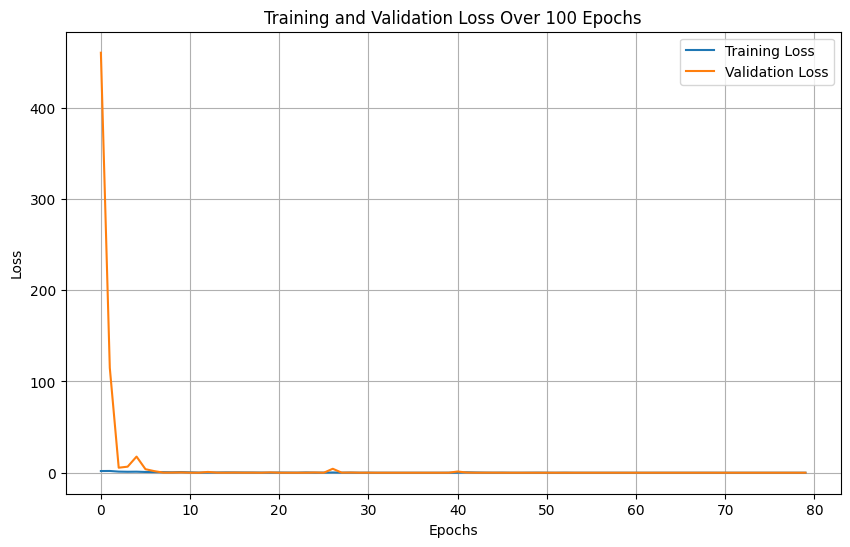

In [89]:
def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over 100 Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, valid_losses)

In [102]:
model.load_state_dict(torch.load('../models/resnet50_trained_7.pth'))
model.eval()

def val_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=25):
    valid_losses = []
    total_val_loss = 0.0
    image = []
    keypoint = []

    with torch.no_grad():
        for images, targets, concat_vecs, labels in valid_loader:
            concat_vecs = torch.stack(concat_vecs).to(device)
            labels = torch.stack([label.to(device) for label in labels])
            ground_truth_keypoints_val = torch.stack([target['keypoints'].to(device) for target in targets])

            print('ground_truth_keypoints_val = ', ground_truth_keypoints_val)
            class_outputs, keypoint_outputs = model(concat_vecs)
            _, predicted = torch.max(class_outputs, 1)
            print('targets = ', targets[0]['keypoints'])
            # print('class_outputs = ', class_outputs)
            print('predicted = ', predicted)
            print('keypoint_outputs = ', keypoint_outputs)
            print('labels = ', labels)
            labels_tuple = tuple(labels[i] for i in range(labels.size(0)))
            labels_tensor = torch.stack(labels_tuple)
            class_indices = torch.argmax(labels_tensor, dim=1)
            
            image.append(images)
            keypoint.append(keypoint_outputs)
            loss = criterion(class_outputs, class_indices)
            total_val_loss += loss.item() * concat_vecs.size(0)
            
    avg_valid_loss = total_val_loss / len(valid_loader.dataset)
    
    valid_losses.append(avg_valid_loss)
    return image, keypoint


In [103]:
images_val, keypoints_val = val_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=75)
print('images_val = ', images_val[0][0].shape)
# val_accuracy = val_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=75)


ground_truth_keypoints_val =  tensor([[[0.6635, 0.6272]],

        [[0.1264, 0.3943]],

        [[0.5586, 0.7833]],

        [[0.3881, 0.4398]],

        [[0.5170, 0.3621]]])
targets =  tensor([[0.6635, 0.6272]])
predicted =  tensor([3, 2, 0, 3, 0])
keypoint_outputs =  tensor([[[-0.3544, -0.5533]],

        [[ 0.1491, -0.2095]],

        [[-0.0207, -0.2356]],

        [[-0.3296, -0.5419]],

        [[-0.0177, -0.2292]]])
labels =  tensor([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]])
ground_truth_keypoints_val =  tensor([[[0.3579, 0.7016]],

        [[0.2048, 0.5586]],

        [[0.3959, 0.5641]],

        [[0.3180, 0.5073]],

        [[0.5273, 0.3969]]])
targets =  tensor([[0.3579, 0.7016]])
predicted =  tensor([0, 0, 1, 3, 1])
keypoint_outputs =  tensor([[[-1.8661e-04, -2.4591e-01]],

        [[ 5.2072e-02, -2.6191e-01]],

        [[ 1.4378e-02, -5.4515e-01]],

        [[-3.5504e-01, -5.9467e-01]],

        [[-2.1297e-02, -5.52

[[-0.35436228 -0.5533216 ]
 [ 0.14914447 -0.20947708]
 [-0.02074478 -0.23563522]
 [-0.3296065  -0.5418839 ]
 [-0.01766888 -0.22923994]]
[-0.35436228 -0.5533216 ]
tensor([54.2336, 37.5210])
model key [-29.766432 -46.479015]
(84, 84, 3)


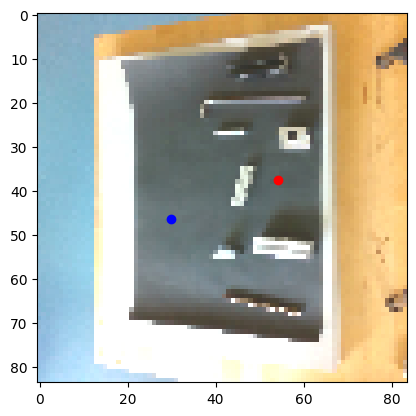

In [117]:
img_size = 84
kp = keypoints_val[0].reshape(-1, 2)
print(np.array(kp))
print(np.array(kp[0]))

denormalized_keypoints = ((kp[0] + 1) * img_size)
# denormalized_keypoints = [52, 40]
print(denormalized_keypoints)

dky = np.array(dk(kp[0],84,84))
print("model key",dky[0])
pic = (images_val[0][0].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)
print(pic.shape)
fig, ax = plt.subplots()

ax.imshow(pic)

ax.plot(denormalized_keypoints[0], denormalized_keypoints[1], 'ro') 
ax.plot(dky[0][0], dky[0][1], 'bo') 

plt.show()


In [42]:
model.load_state_dict(torch.load('../models/resnet50_trained_3.pth'))
model.eval()

# Function to evaluate the model on validation and test sets
def evaluate_model(model, data_loader):
    correct = total = 0
    with torch.no_grad():
        for inputs, targets, concat_vecs, labels in data_loader:
            concat_vecs, labels = torch.stack(concat_vecs).to(device), [label.to(device) for label in labels]
            outputs = model(concat_vecs)
            _, predicted = torch.max(outputs, 1)
            print(np.array(labels).shape[0])
            total += np.array(labels).shape[0]
            correct_pred = (predicted == labels)
            print(predicted)
            total_correct = correct_pred.sum().item()
            correct += total_correct
    return 100 * correct / total

In [43]:
val_accuracy = evaluate_model(model, valid_loader)
# test_accuracy = evaluate_model(model, test_loader)

print(f'Validation Accuracy: {val_accuracy:.2f}%')

TypeError: max() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


labels tensor([[0.2591, 0.3141]])
keypoints tensor([[0.2591, 0.3141]])
image shape (224, 224, 3)
denormalized [[tensor(58.0333), tensor(70.3500)]]
kp [[58, 70]]
[[21, 26]]


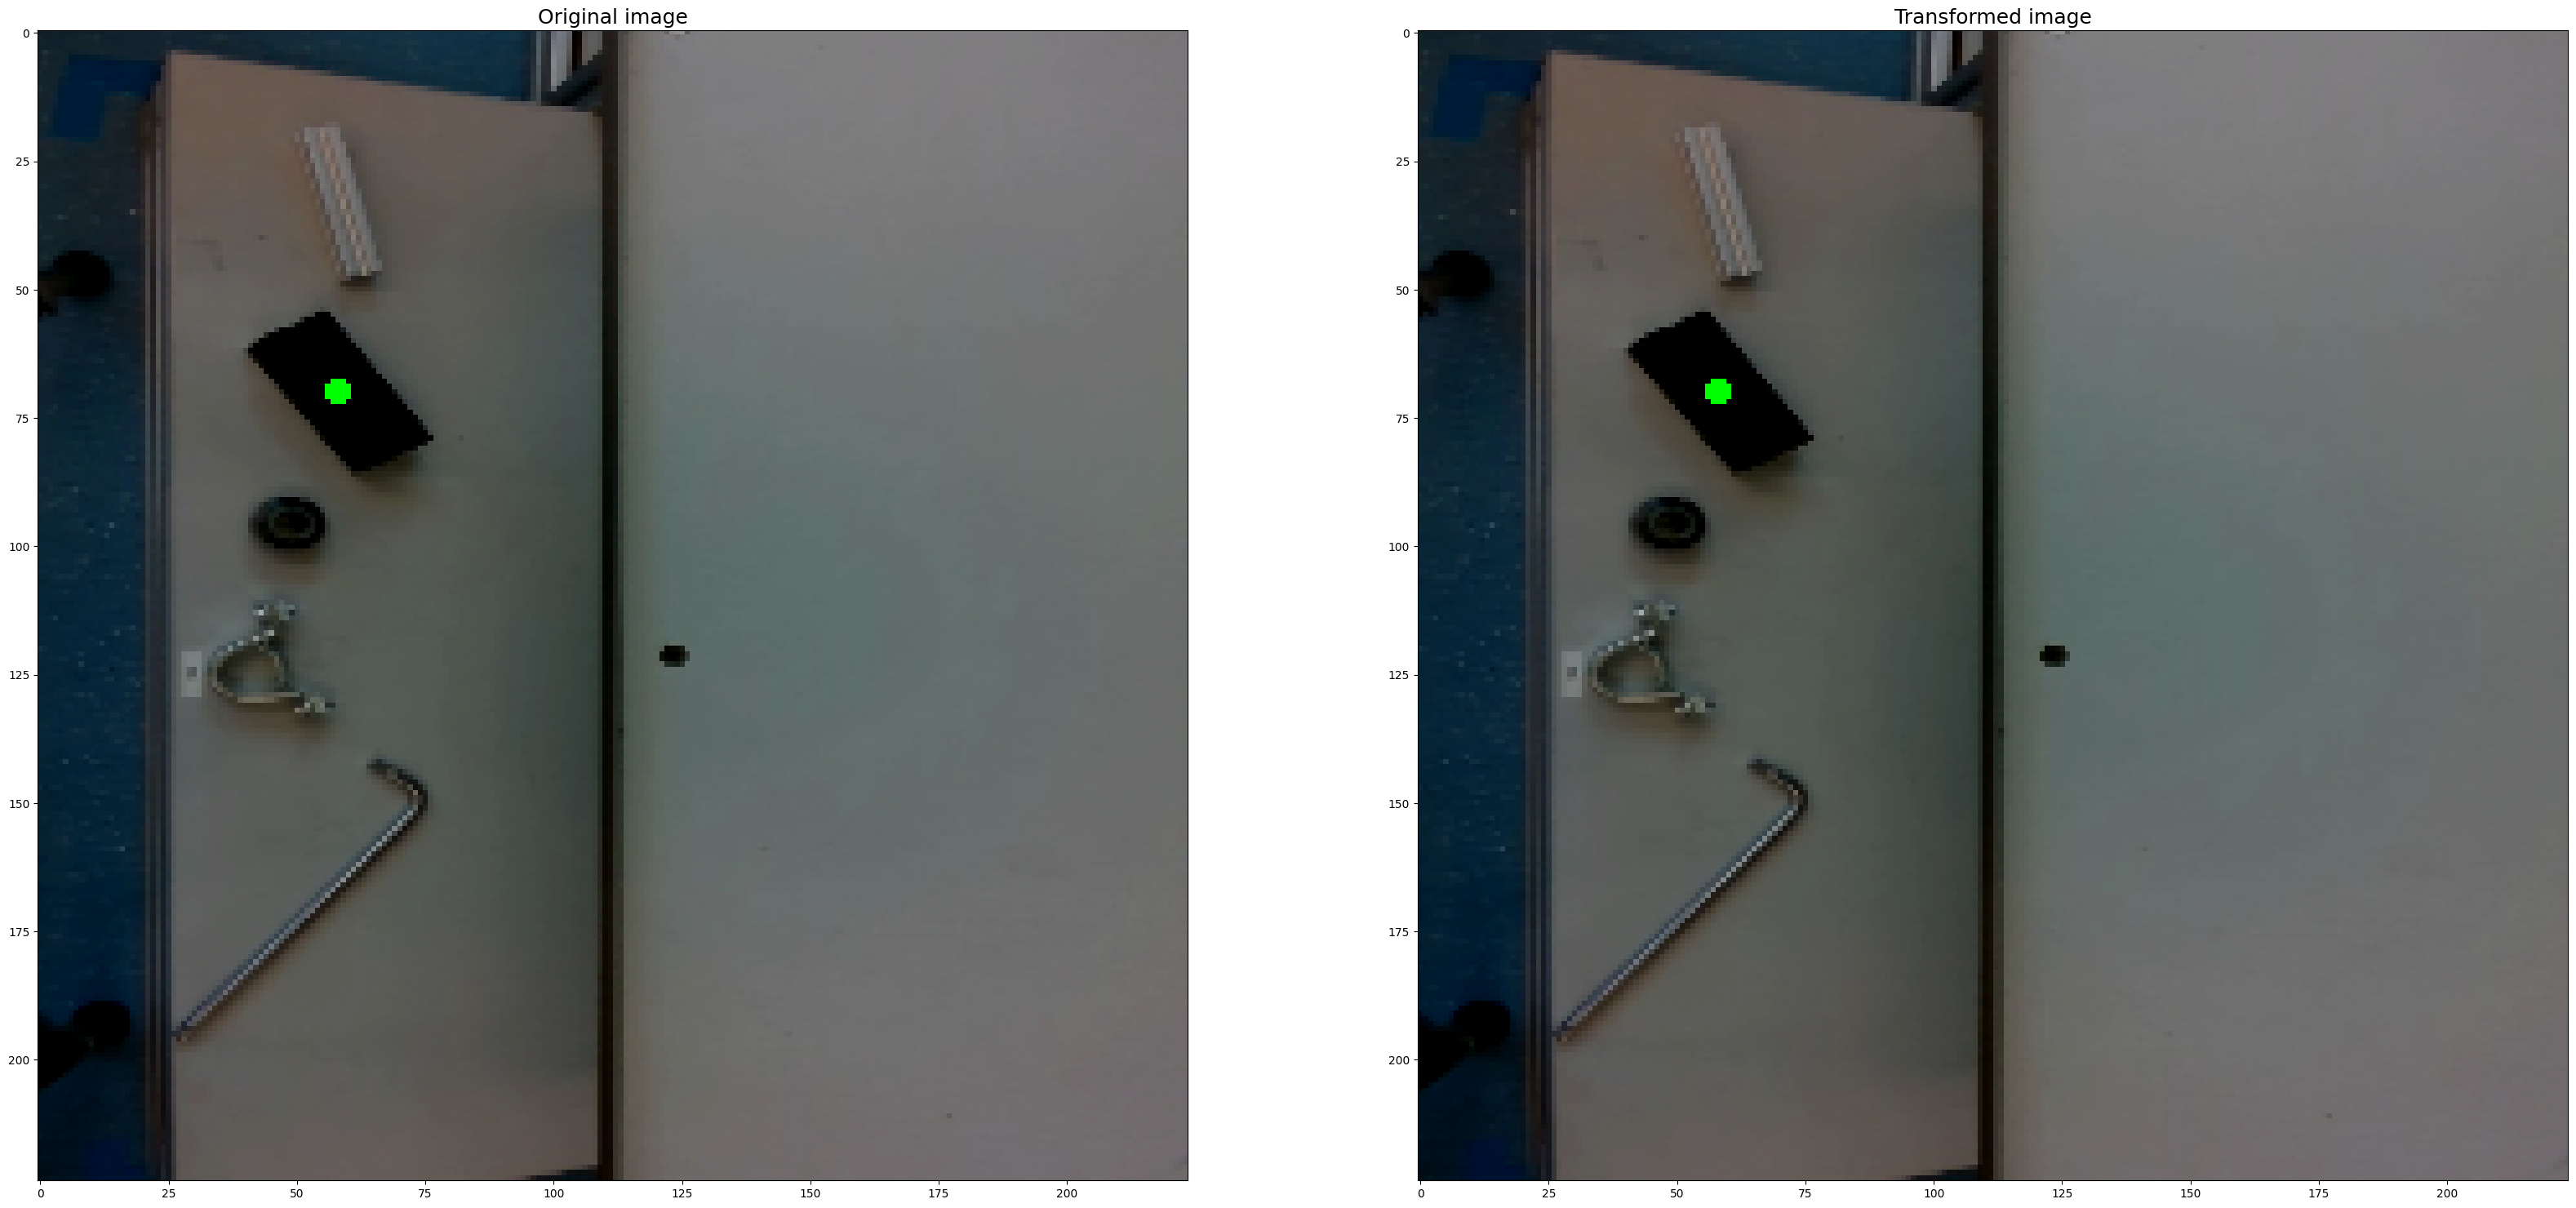

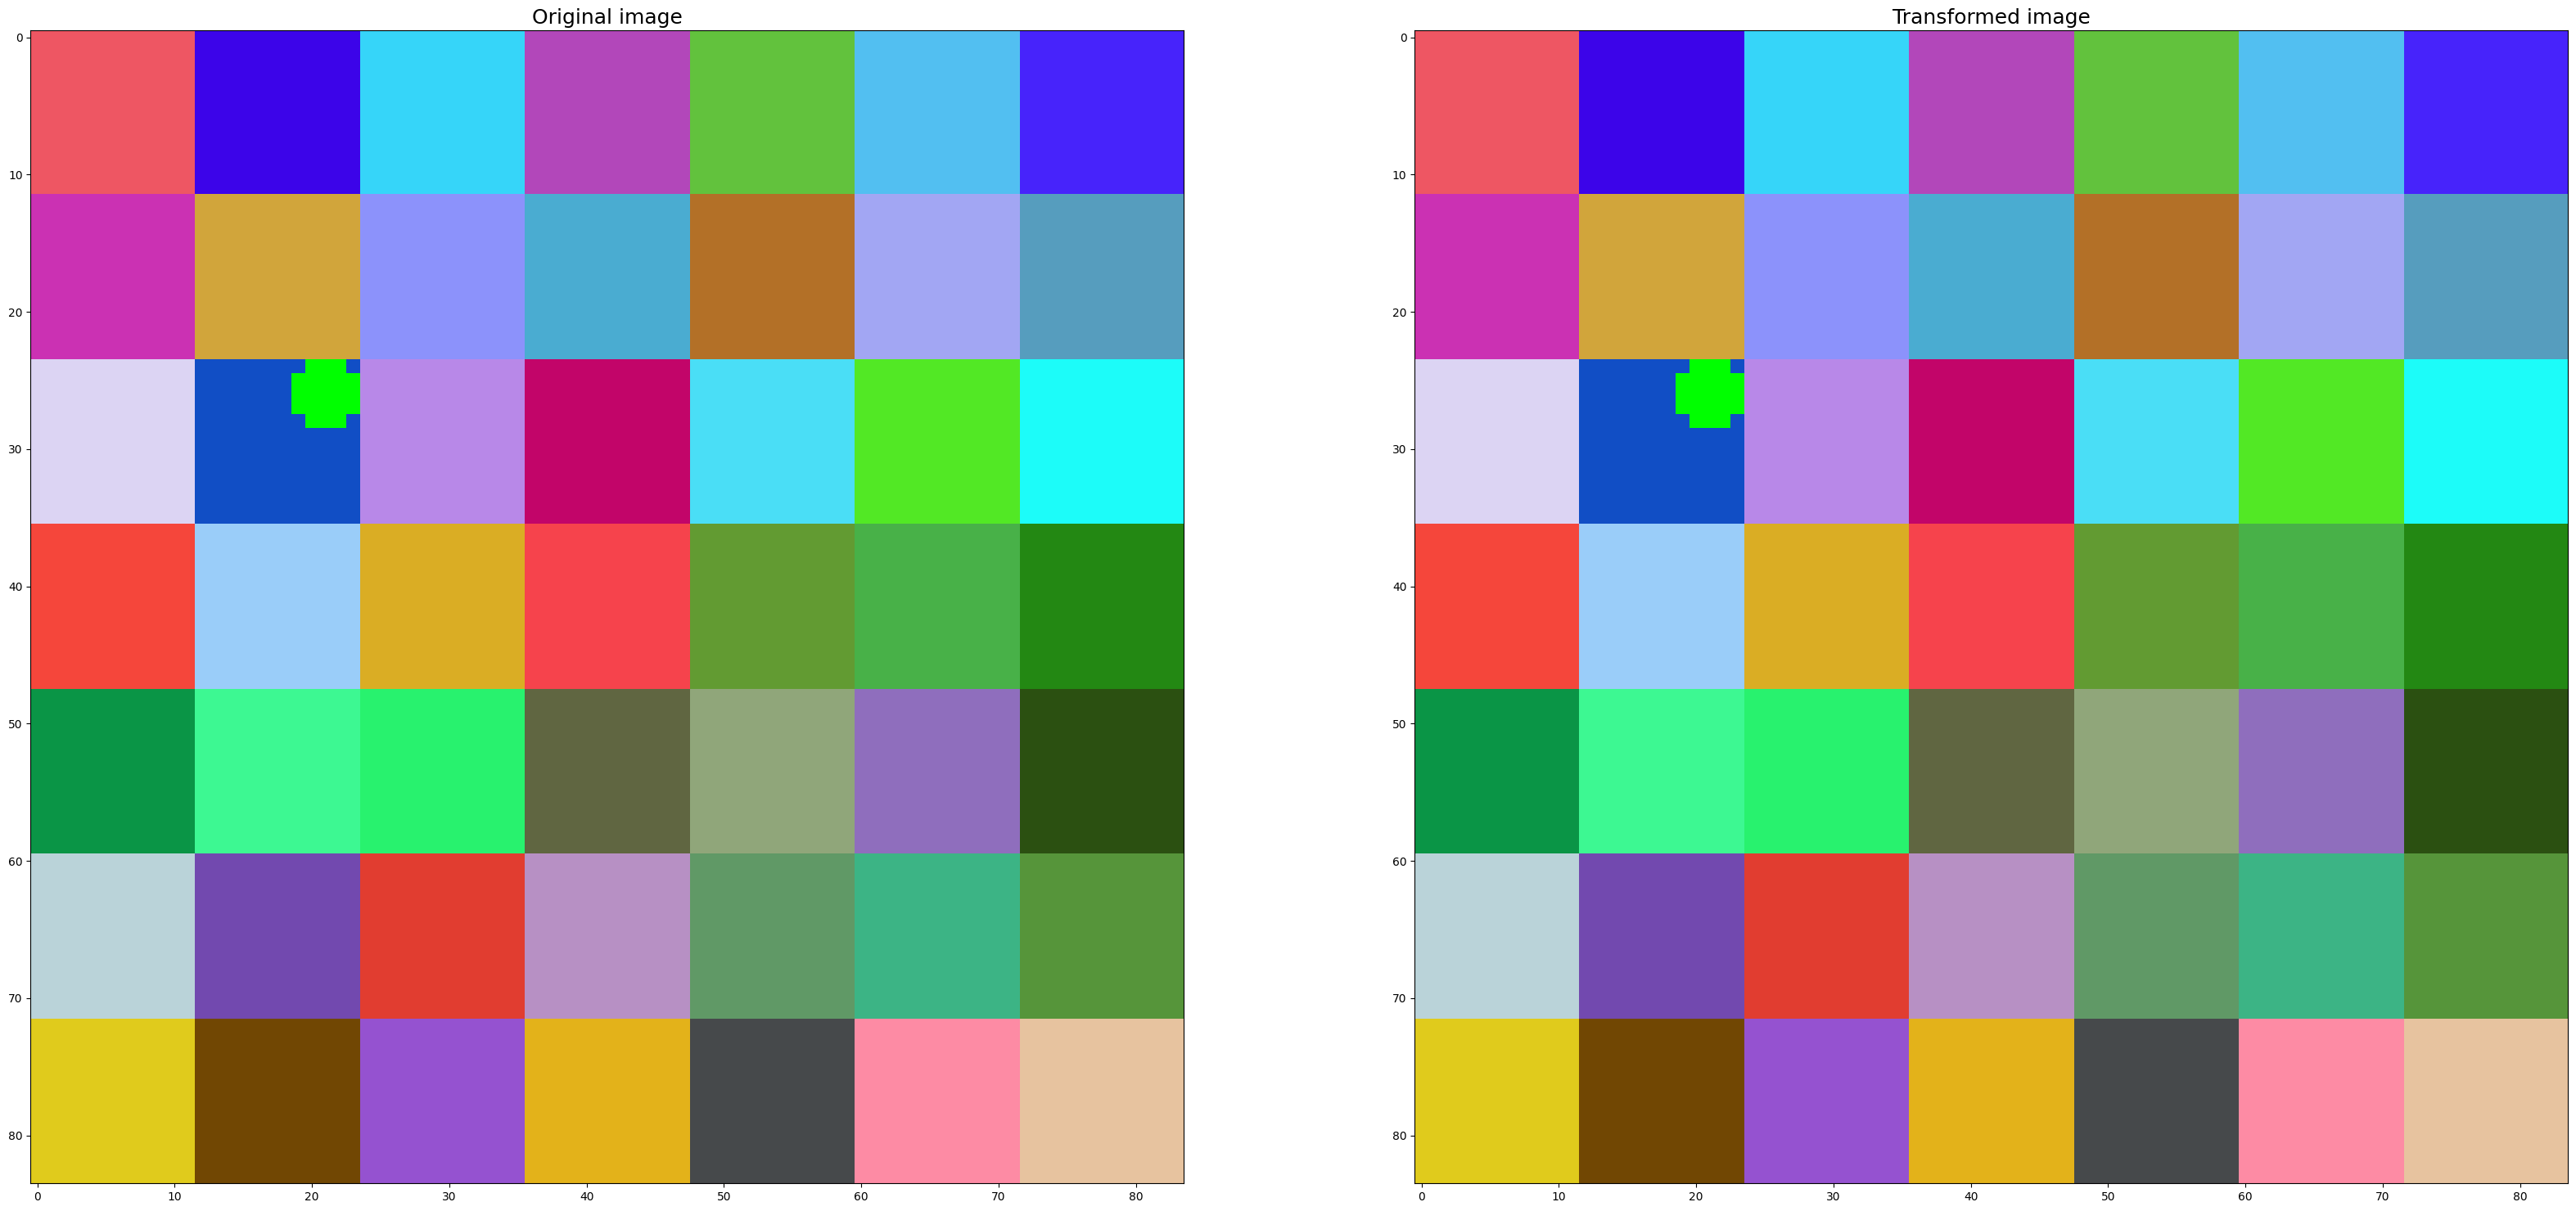

In [222]:
def visualize(image, bboxes, image_original=None, bboxes_original=None):
    fontsize = 18

    for bbox in bboxes:
        # for keypoints
        keypoint = (bbox[0], bbox[1])
        image = cv2.circle(image.copy(), keypoint, 1, (0,255,0), 2)
        # for bbox
        # start_point, end_point = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        # image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)


    if image_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            # for keypoints
            keypoint = (bbox[0], bbox[1])
            image_original = cv2.circle(image_original.copy(), keypoint, 1, (0,255,0), 2)
            # for bbox
            # start_point, end_point = (bbox[0], bbox[1]), (bbox[2], bbox[3])
            # image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)


        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

image1 = (img[image_number].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)
image = (images[image_number].permute(1,2,0).detach().numpy() * 255).astype(np.uint8)

print('labels',labels[image_number]['keypoints'])

# keypoints = labels[image_number]['keypoints'].detach().cpu().numpy().astype(np.float32).tolist()
keypoints = labels[image_number]['keypoints']
keypo = keyp[image_number].detach().cpu().numpy().astype(np.int32).tolist()

print ('keypoints',keypoints)
print ('image shape',image.shape)

keypoints = denormalize_keypoints(keypoints, image.shape[0], image.shape[1])
print ('denormalized',keypoints)
kp = [[int(t.item()) for t in sublist] for sublist in keypoints]
print ('kp',kp)

# visualize(image, bboxes, image, bboxes)
visualize(image, kp, image, kp)
print(keypo)
visualize(image1, keypo, image1, keypo)